In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tqdm
import glob
import tensorflow 
import seaborn as sns


from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
!pip install tensorflow

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=30, zoom_range=0.2, horizontal_flip=True, vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [4]:
train_dataset  = train_datagen.flow_from_directory(directory = './Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 4098 images belonging to 4 classes.


In [5]:
valid_dataset = valid_datagen.flow_from_directory(directory = './Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 1023 images belonging to 4 classes.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


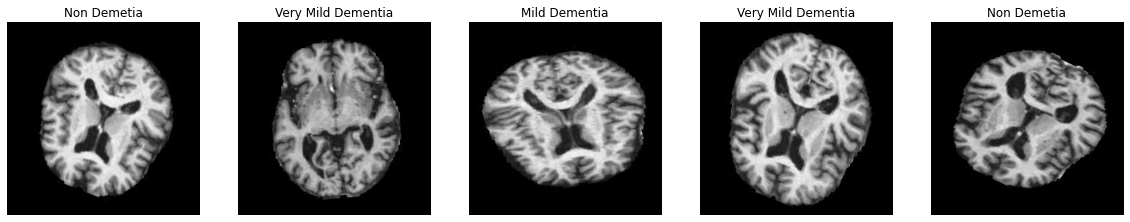

In [6]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

In [27]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
base_model = DenseNet169(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")

In [8]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [9]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [10]:
# Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 dropout (Dropout)           (None, 7, 7, 1664)        0         
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 batch_normalization (Batch  (None, 81536)             326144    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 2048)              166987776 
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                       

In [11]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [12]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [13]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 10,
                        callbacks = callback_list,
                        verbose = 1)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Epoch 1/10

33/33 [==============================] - ETA: 0s - loss: 1.3367 - auc: 0.7886 
Epoch 1: val_auc improved from -inf to 0.72216, saving model to .\best_weights.hdf5


C:\Users\Lenovo\jupyter\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 835s 24s/step - loss: 1.3367 - auc: 0.7886 - val_loss: 3.1520 - val_auc: 0.7222
Epoch 2/10
33/33 [==============================] - ETA: 0s - loss: 1.0846 - auc: 0.8317 
Epoch 2: val_auc did not improve from 0.72216
33/33 [==============================] - 629s 19s/step - loss: 1.0846 - auc: 0.8317 - val_loss: 2.4679 - val_auc: 0.6970
Epoch 3/10
33/33 [==============================] - ETA: 0s - loss: 0.9949 - auc: 0.8489 
Epoch 3: val_auc improved from 0.72216 to 0.76097, saving model to .\best_weights.hdf5
33/33 [==============================] - 490s 15s/step - loss: 0.9949 - auc: 0.8489 - val_loss: 1.8197 - val_auc: 0.7610
Epoch 4/10
33/33 [==============================] - ETA: 0s - loss: 0.9460 - auc: 0.8578 
Epoch 4: val_auc did not improve from 0.76097
33/33 [==============================] - 426s 13s/step - loss: 0.9460 - auc: 0.8578 - val_loss: 1.6036 - val_auc: 0.7465
Epoch 5/10
33/33 [==============================] - ETA: 0s - loss:

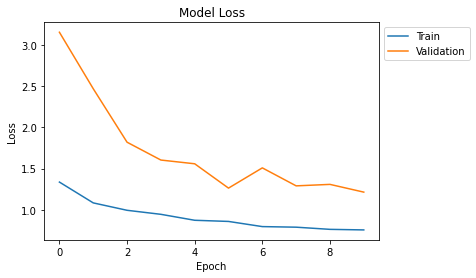

In [14]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

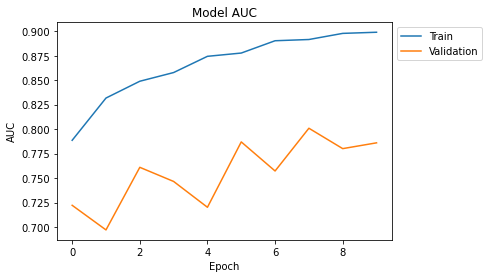

In [15]:
# Summarize history for AUC

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [28]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = './Alzheimer_s Dataset/test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 128)

Found 1279 images belonging to 4 classes.


In [17]:
# Evaluating Loss and AUC

model.evaluate(test_dataset)

10/10 [==============================] - 51s 5s/step - loss: 0.8460 - auc: 0.8821


[0.8459504246711731, 0.8820748925209045]

1/1 [==============================] - 4s 4s/step
100.0 % chances are there that the image is VeryMildDemented


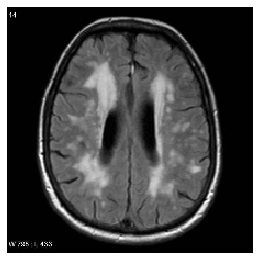

In [18]:
# Test Case 1: Very Mild-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('./Alzheimer_s Dataset/test/sample_image.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)
probability = round((np.max(img)*100),2)
predicted_class_index = np.argmax(answer)
predicted_class = idc[predicted_class_index]
print(probability, '% chances are there that the image is',predicted_class)

1/1 [==============================] - 0s 164ms/step
77.79 % chances are there that the image is VeryMildDemented


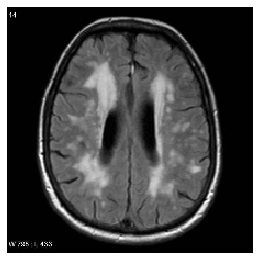

In [19]:
dic = test_dataset.class_indices
idc = {k: v for v, k in dic.items()}

img = load_img('./Alzheimer_s Dataset/test/sample_image.jpg', target_size=(224, 224, 3))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img, axis=0)
predictions = model.predict(img)
answer = np.argmax(predictions, axis=1)
probability = round(np.max(predictions) * 100, 2)
output=idc[answer[0]]

print(probability, '% chances are there that the image is', output)

In [20]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from neuralintents.assistants import BasicAssistant

own_layers = [
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5)
]

if output=="NonDemented":
    intents="common_intents.json"
else:
    intents=f'{output}_intents.json'

assistant = BasicAssistant(intents, hidden_layers=own_layers, model_name=output)

if os.path.exists(f'output.keras'):
    assistant.load_model()
else:
    assistant.fit_model(epochs=50)
    assistant.save_model()
    
assistant.model.summary()

done = False

print("Hey, hope you are doing well. Based on your MRI scan,there is a",probability,
      "% chances are there that the image is",predicted_class)

while not done:
    message = input("Enter a message: ")
    if message == "STOP":
        done = True
    else:
        print(assistant.process_input(message))

Epoch 1/50

5/5 [==============================] - 5s 5ms/step - loss: 2.5808 - accuracy: 0.0952
Epoch 2/50
5/5 [==============================] - 0s 3ms/step - loss: 2.2035 - accuracy: 0.2381
Epoch 3/50
5/5 [==============================] - 0s 2ms/step - loss: 2.0311 - accuracy: 0.3810
Epoch 4/50
5/5 [==============================] - 0s 3ms/step - loss: 1.9755 - accuracy: 0.3810
Epoch 5/50
5/5 [==============================] - 0s 3ms/step - loss: 1.5532 - accuracy: 0.5714
Epoch 6/50
5/5 [==============================] - 0s 3ms/step - loss: 1.4747 - accuracy: 0.5714
Epoch 7/50
5/5 [==============================] - 0s 3ms/step - loss: 1.2380 - accuracy: 0.6667
Epoch 8/50
5/5 [==============================] - 0s 3ms/step - loss: 1.2973 - accuracy: 0.4762
Epoch 9/50
5/5 [==============================] - 0s 3ms/step - loss: 1.1962 - accuracy: 0.5714
Epoch 10/50
5/5 [==============================] - 0s 2ms/step - loss: 1.1436 - accuracy: 0.4286
Epoch 11/50
5/5 [=====================

8/8 [==============================] - 41s 5s/step


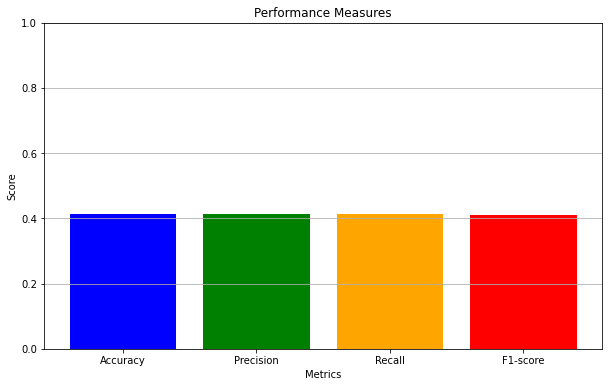

In [25]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
y_pred_probabilities = model.predict(valid_dataset)
y_pred = np.argmax(y_pred_probabilities, axis=1)  # Convert probabilities to class labels

# Extract true labels
y_true = valid_dataset.classes

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)

# Compute precision
precision = precision_score(y_true, y_pred, average='weighted', labels=np.unique(y_pred), zero_division=0)

# Compute recall
recall = recall_score(y_true, y_pred, average='weighted', labels=np.unique(y_pred))

# Compute F1-score
f1 = f1_score(y_true, y_pred, average='weighted', labels=np.unique(y_pred), zero_division=0)

# Generate classification report
report = classification_report(y_true, y_pred)

labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'green', 'orange', 'red'])
plt.title('Performance Measures')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)  # Setting y-axis limit to [0, 1] for better visualization
plt.grid(axis='y')
plt.show()

# warning:
# What happens here is that the labels that were not predicted at all are simply ignored.When true positive + 
# false positive == 0, precision is undefined; When true positive + false negative == 0, recall is undefined. In such cases,
# by default the metric will be set to 0, as will f-score, and UndefinedMetricWarning will be raised. This behavior can be 
# modified with zero_division.
# the zero_division default value is "warn", you could set it to 0 or 1 to avoid UndefinedMetricWarning. it works for me ;) oh wait, there is another problem when i using zero_division, my sklearn report that no such keyword argument by using scikit-learn 0.21.3. Just update your sklearn to the latest version by running pip install scikit-learn -U


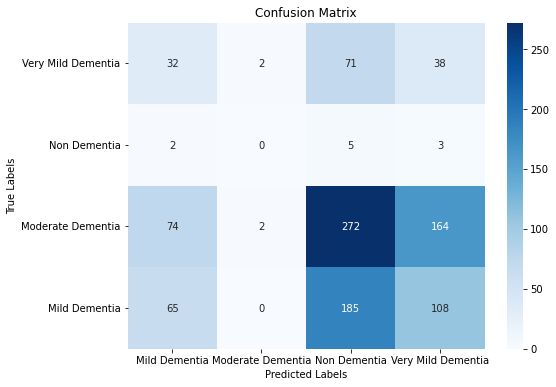

In [22]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Mild Dementia', 'Moderate Dementia', 'Non Dementia', 'Very Mild Dementia'], 
            yticklabels=['Very Mild Dementia', 'Non Dementia', 'Moderate Dementia', 'Mild Dementia'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()